In [1]:
# Importing libraries
from copy import deepcopy
import random


# Math Libraries
import random
import math
import numpy as np

# Data Processing
import pandas as pd

# Libraries for data visualization
import matplotlib.pyplot as plt  
import seaborn as sns 
from sympy import var, plot_implicit

# ML
from sklearn.linear_model import LogisticRegression # Importing Logistic Model
from sklearn.model_selection import train_test_split # Train Test Split
from sklearn.preprocessing import MinMaxScaler # Data normalizer Min Max Scale
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error # Calculate the accuracy

# Loading Bar
from time import sleep
from tqdm import tqdm

# Convex Hull
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
from numpy.linalg import det
from scipy.stats import dirichlet
from scipy.spatial.distance import euclidean
from scipy import stats as st
from scipy.optimize import fmin_tnc

# Supress warnings
import warnings; warnings.simplefilter('ignore')

In [2]:
def Adult_Data_Clean(df: pd.DataFrame) -> pd.DataFrame:
  # Changing collumn names for convenience
  df.rename(columns={'capital-gain': 'gain', 'capital-loss': 'loss', 'native-country': 'country',
                    'hours-per-week': 'hours','marital-status': 'marital'}, inplace=True)
  
  # Finding not known data
  df['country'] = df['country'].replace('?',np.nan)
  df['workclass'] = df['workclass'].replace('?',np.nan)
  df['occupation'] = df['occupation'].replace('?',np.nan)
  
  # Dropping not known data
  df.dropna(how='any',inplace=True)

  # Normalizing numerical features
  numerical = ['age', 'fnlwgt', 'educational-num', 'gain', 'loss', 'hours']
  scaler = MinMaxScaler()
  df[numerical] = scaler.fit_transform(df[numerical])  
  return df

In [3]:
# Loading Dataset
adult_folder = pd.read_csv('adult.csv') # Loading Adult

In [4]:
adult_dataset = Adult_Data_Clean(adult_folder)

# Separating label (income) from the rest of the data and making income binary
income_raw = adult_dataset['income'].tolist()
adult_dataset = adult_dataset.drop(['income'], axis=1)
income = pd.Series(income_raw).astype('category').cat.codes.tolist()
adult_dataset.drop(adult_dataset.columns.difference(['age', 'educational-num', 'gender', 'loss', 'hours']), 1, inplace=True)
#adult_dataset.drop(adult_dataset.columns.difference(['educational-num']), 1, inplace=True)
income = np.array(income)

In [5]:
# One-Hot encoding
per_adult_encoded = pd.get_dummies(adult_dataset)

In [6]:
# Spliting dataset
X_train, X_test, Y_train, Y_test = train_test_split(per_adult_encoded, income, test_size = 0.5, random_state = 0)

## Implementing logistic RegressioN

In [7]:
def sigmoid(x):
    # Activation function used to map any real value between 0 and 1
    return 1 / (1 + np.exp(-x))

def net_input(theta, x):
    # Computes the weighted sum of inputs
    return np.dot(x, theta)

def probability(theta, x):
    # Returns the probability after passing through sigmoid
    return sigmoid(net_input(theta, x))

def get_prediction(theta, x):
    return (probability(theta, x) > 0.5)*1

def get_accuracy(theta, x, y):
    return np.mean(get_prediction(theta, x) == y)

In [8]:
def cost_function(theta, x, y):
    # Computes the cost function for all the training samples
    m = x.shape[0]
    total_cost = -(1 / m) * np.sum(
        y * np.log(probability(theta, x)) + (1 - y) * np.log(
            1 - probability(theta, x)))
    return total_cost

def gradient(theta, x, y):
    # Computes the gradient of the cost function at the point theta
    m = x.shape[0]
    return (1 / m) * np.dot(x.T, sigmoid(net_input(theta,   x)) - y)

In [9]:
def fit(x, y, theta):
    opt_weights = fmin_tnc(func=cost_function, x0=theta,
                  fprime=gradient,args=(x, y.flatten())) ;
    
    return opt_weights[0]


X = np.c_[np.ones((X_train.shape[0], 1)), X_train]
theta = np.zeros((X.shape[1], 1))
parameters = fit(X, Y_train, theta)

  NIT   NF   F                       GTG
    0    1  6.931471805599452E-01   1.26191641E-01
    1    4  5.383188095841123E-01   2.08581688E-03
tnc: fscale = 21.8959
    2    8  4.433083945611180E-01   1.64541137E-03
    3   12  4.318785699126444E-01   9.98432198E-05
    4   16  4.301728999221504E-01   2.95243802E-05
    5   20  4.295772280363814E-01   2.64152047E-06
tnc: fscale = 615.28
    6   24  4.294342952681910E-01   5.09196604E-08
    7   28  4.294233031500191E-01   1.13430046E-08
    8   32  4.294209577704940E-01   1.21546190E-08
    9   36  4.294208614688699E-01   2.76937734E-13
tnc: |pg| = 8.55299e-10 -> local minimum
    9   36  4.294208614688699E-01   2.76937734E-13
tnc: Local minima reach (|pg| ~= 0)


## Calculating the Rashomon set

### Finding points in the border

In [10]:
center = parameters
delta = 0.1 #Size of initial noise
samples = 1000 #number of directions

epsilon = 0.1 * cost_function(center, X, Y_train) #Rashomon set size

extremes_l = np.zeros((samples, center.size))

early_stopping_exploration = 1000
for i in tqdm(range(samples)):
    #Generationg direction
    Z = np.random.normal(loc=0.0, scale=1.0, size=center.size)
    Z = Z/np.linalg.norm(Z)
    direction = center + delta * Z
    #loading model
    ct = 1
    while (cost_function(direction, X, Y_train) - cost_function(center, X, Y_train)) < epsilon:
        extremes_l[i, :] = direction
        direction = center + ct*delta*Z
        ct += 1
        if ct==early_stopping_exploration:
            break

100%|███████████████████████████████████████| 1000/1000 [34:17<00:00,  2.06s/it]


In [11]:
np.sum(extremes_l == [0,0])

0

### Getting convex hull and triangulation

In [12]:
# Sampling from Rashomon set after calculating cvx hull and triangulation
def samp_in_hull_after(deln, vols, n):
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())
    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))

In [13]:
dims = extremes_l.shape[-1] #get dim
hull = extremes_l[ConvexHull(extremes_l).vertices] #get hull
deln = hull[Delaunay(hull).simplices] #get Delunay
vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims) #get areas

### Sampling models in ensamble

In [14]:
n = 1000 #number of models in the ensamblex
models_in_ensemble = samp_in_hull_after(deln, vols, n)

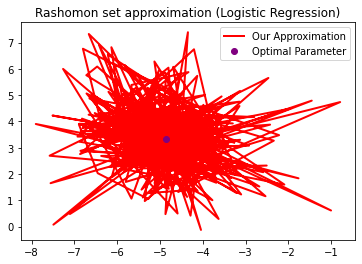

In [15]:
#plt.plot(extremes_l[:, 0], extremes_l[:, 1], 'o', color='black');
plt.plot(hull[:, 0], hull[:, 1], lw=2, color = 'red', label = 'Our Approximation')
plt.plot(center[0], center[ 1], 'o', color='purple', label = 'Optimal Parameter');
plt.plot([hull[0, 0], hull[-1, 0]], [hull[0, 1], hull[-1, 1]], lw=2, color = 'red')
plt.legend()
plt.title('Rashomon set approximation (Logistic Regression)');
plt.savefig('Rashomon_logistic_set.pdf')

## Getting mode predictor

In [16]:
def get_mode_prediction(models_in_ensemble, x):
    n_models = models_in_ensemble.shape[0]
    pred = np.zeros((n_models, x.shape[0]))
    for i in range(n_models):
        pred[i] = get_prediction(models_in_ensemble[i], x) 
        
    return st.mode(pred)[0] #np.mean(pred, axis = 0) 

In [17]:
get_mode_prediction(models_in_ensemble, X)

array([[0., 1., 0., ..., 0., 0., 0.]])

### Evaluating mode

In [18]:
montecarlo_tries = 200
avg_ensamble_disagreement = 0
avg_optimal_disagreement = 0

n_range= np.array([10000])
n_size = len(n_range)
acc_ensembles = np.zeros(n_size)
disagreements_difference = np.zeros(n_size)
pred = get_prediction(center, X)

for j in tqdm(range(n_size)):
    avg_ensamble_disagreement = 0
    avg_optimal_disagreement = 0
    
    models_in_ensemble = samp_in_hull_after(deln, vols, n_range[j])
    ensamble_predition = get_mode_prediction(models_in_ensemble, X)
    
    for i in range(montecarlo_tries):    
        random_model_pred = get_prediction(samp_in_hull_after(deln, vols, 1)[0], X)
        
        avg_ensamble_disagreement += np.sum(ensamble_predition != random_model_pred)
        avg_optimal_disagreement += np.sum(pred != random_model_pred)
    
    print( (avg_ensamble_disagreement - avg_optimal_disagreement) /  montecarlo_tries )
    
    disagreements_difference[j] = (avg_optimal_disagreement-avg_ensamble_disagreement) / montecarlo_tries
    acc_ensembles[j] = np.mean(ensamble_predition == Y_train)



100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.58s/it]

-11.9


In [ ]:
acc_ensembles, disagreements_difference

In [ ]:
get_accuracy(parameters, X, Y_train)

## Getting percentage of different predictions

In [ ]:
def get_all_prediction(models_in_ensemble, x):
    n_models = models_in_ensemble.shape[0]
    pred = np.zeros((n_models, x.shape[0]))
    for i in range(n_models):
        pred[i] = get_prediction(models_in_ensemble[i], x) 
        
    return pred

In [ ]:
models_in_ensemble = samp_in_hull_after(deln, vols, 10000)

In [ ]:
predictions = get_all_prediction(models_in_ensemble, X)

In [ ]:
prob = np.mean(predictions, axis = 0)

In [ ]:
plt.hist(prob, bins=5)
plt.xlabel('Prob. of prediction = 1')
plt.savefig('histogram_high_freq.pdf')
plt.show()